
----
# Cuaderno 9 - Random Forest
## Ariel Palazzesi - 2026
----


En este cuaderno vamos a entrenar y evaluar un modelo de clasificación basado en **Random Forest**, un conjunto de árboles de decisión que trabajan de forma conjunta para mejorar la precisión del modelo.

Utilizaremos el dataset del Titanic para predecir si una persona sobrevivió o no (`Survived`) a partir de sus características personales y de viaje.

Este cuaderno incluye:
- Entrenamiento de un modelo `RandomForestClassifier` con parámetros por defecto.
- Evaluación del modelo con métricas conocidas.
- Visualización de la **importancia de las variables**.
- Comparación con el árbol individual entrenado en el cuaderno anterior.




## Random Forest: conjuntos de árboles para decisiones más robustas

**Random Forest** es un algoritmo de **aprendizaje supervisado** que se utiliza tanto para **clasificación** como para regresión. Puede entenderse como una **evolución de los árboles de decisión**, diseñada para resolver uno de sus principales problemas: el sobreajuste.

La idea central de Random Forest es simple pero poderosa:
en lugar de confiar en un solo árbol de decisión, el modelo construye **muchos árboles distintos** y combina sus resultados para tomar una decisión final. Este enfoque se conoce como **aprendizaje por conjuntos** (*ensemble learning*).

---

### Idea (intuitiva) del funcionamiento

Imaginemos que queremos predecir si un cliente va a abandonar un servicio. En lugar de pedir la opinión de una sola persona (un árbol), consultamos a **un grupo grande de personas**, cada una con información parcial y criterios ligeramente distintos.

* Cada árbol del bosque analiza el problema desde un punto de vista diferente.
* Algunos árboles pueden equivocarse.
* Pero, al combinar las decisiones de todos, el resultado final suele ser más estable y confiable.

En clasificación, Random Forest toma la **decisión por votación mayoritaria** entre los árboles. En regresión, promedia las predicciones.

---

### ¿Por qué los árboles son diferentes entre sí?

Random Forest introduce **aleatoriedad** de dos formas principales para que los árboles no sean idénticos:

1. **Muestreo de datos (bootstrap):**
   Cada árbol se entrena con una muestra aleatoria del conjunto de entrenamiento, tomada con reemplazo. Esto hace que cada árbol vea datos ligeramente distintos.

2. **Selección aleatoria de variables:**
   En cada nodo del árbol, no se evalúan todas las variables disponibles, sino solo un subconjunto aleatorio. Esto obliga a los árboles a explorar diferentes combinaciones de variables y evita que todos se basen siempre en las mismas.

Gracias a esta doble aleatoriedad, los árboles cometen errores distintos entre sí, lo que hace que el promedio o la votación final reduzca el impacto de esos errores individuales.

---

### Ejemplo:

Supongamos un problema de clasificación binaria: decidir si una solicitud de crédito debe ser aprobada o no.

* Un árbol puede basarse principalmente en el ingreso del solicitante.
* Otro puede priorizar la antigüedad laboral.
* Otro puede dar más peso al historial de pagos.
* Otro puede combinar varias de estas variables de forma distinta.

Cada árbol llega a una decisión. Random Forest **combina todas esas decisiones** y elige la más frecuente como resultado final.

---

### Ventajas y limitaciones

Random Forest suele ofrecer un **muy buen rendimiento** incluso sin demasiada optimización. Es más resistente al ruido que un solo árbol y reduce significativamente el riesgo de sobreajuste. Además, permite estimar la **importancia de las variables**, lo que ayuda a interpretar qué factores influyen más en las predicciones.

Como contrapartida, al estar formado por muchos árboles, pierde parte de la interpretabilidad directa que tenía un único árbol de decisión. También puede requerir más recursos computacionales, especialmente cuando se utilizan muchos árboles o datasets grandes.

---

### Random Forest en scikit-learn

En scikit-learn, Random Forest se implementa siguiendo la misma interfaz que otros modelos: se entrena con `fit()` y se utiliza para predecir con `predict()`. Por su equilibrio entre rendimiento, robustez y facilidad de uso, es uno de los algoritmos más populares y utilizados en proyectos reales de Machine Learning.



## Carga del dataset

Vamos a trabajar nuevamente con el archivo `Titanic-Dataset.csv`, que ya deberías tener en tu entorno de Google Colab.

En el siguiente bloque vamos a importar las librerías necesarias y cargar el archivo. Luego verificaremos que los datos se hayan cargado correctamente mostrando las primeras filas.


In [ ]:
# Importamos las librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Scikit-learn para modelado y evaluación
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Cargamos el dataset
ruta = "/content/Titanic-Dataset.csv"
df = pd.read_csv(ruta)

# Mostramos las primeras filas
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preparación del dataset

Para entrenar el modelo, vamos a realizar los siguientes pasos:

- Codificar la variable `Sex` (0 = male, 1 = female).
- Seleccionar las variables predictoras más relevantes.
- Eliminar filas con valores faltantes.
- Separar las variables predictoras (`X`) de la variable objetivo (`y`).

Recordá que Random Forest **no necesita que escalemos las variables**, pero sí que trabajemos solo con datos numéricos y completos.


In [ ]:
# Copiamos el DataFrame original para no modificarlo
df_rf = df.copy()

# Codificamos la variable 'Sex'
df_rf['Sex_encoded'] = df_rf['Sex'].map({'male': 0, 'female': 1})

# Seleccionamos las columnas de interés
columnas = ['Survived', 'Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch']
df_rf = df_rf[columnas]

# Eliminamos filas con valores faltantes
df_rf = df_rf.dropna()

# Definimos variables predictoras (X) y variable objetivo (y)
X = df_rf.drop(columns='Survived')
y = df_rf['Survived']

# Mostramos las primeras filas de X
X.head()


,Pclass,Sex_encoded,Age,SibSp,Parch
0,3,0,22.0,1,0
1,1,1,38.0,1,0
2,3,1,26.0,0,0
3,1,1,35.0,1,0
4,3,0,35.0,0,0


## Entrenamiento del modelo Random Forest

Vamos a dividir el conjunto de datos en entrenamiento (80%) y prueba (20%) usando `train_test_split`. Luego entrenaremos un modelo `RandomForestClassifier` utilizando los parámetros por defecto, que incluyen 100 árboles y selección aleatoria de variables.

Este modelo combinará múltiples árboles de decisión para generar una predicción robusta por votación.


In [ ]:
# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos el modelo Random Forest con parámetros por defecto
modelo_rf = RandomForestClassifier(random_state=42)

# Entrenamos el modelo
modelo_rf.fit(X_train, y_train)

# Verificamos entrenamiento: mostramos los primeros 10 resultados
y_pred = modelo_rf.predict(X_test)
print("Primeras 10 predicciones:", y_pred[:10])


Primeras 10 predicciones: [1 1 1 1 0 1 0 1 1 1]


## Evaluación del modelo Random Forest

Ahora vamos a evaluar el rendimiento del modelo utilizando:

- **Reporte de clasificación**: incluye precisión, recall y F1-score para cada clase.
- **Matriz de confusión**: nos muestra en qué tipos de errores incurre el modelo.

Esto nos permitirá compararlo más adelante con el árbol de decisión individual entrenado en la clase anterior.


In [ ]:
# Reporte de clasificación
print("Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        87
           1       0.66      0.73      0.69        56

    accuracy                           0.75       143
   macro avg       0.74      0.75      0.74       143
weighted avg       0.75      0.75      0.75       143

Matriz de confusión:
[[66 21]
 [15 41]]


## Importancia de las variables

`Random Forest` permite conocer la importancia relativa de cada variable, es decir, cuánto contribuyó cada una a reducir la impureza en los nodos del bosque.

Vamos a visualizar esta información con un gráfico de barras para interpretar qué variables tuvieron más peso en la clasificación.


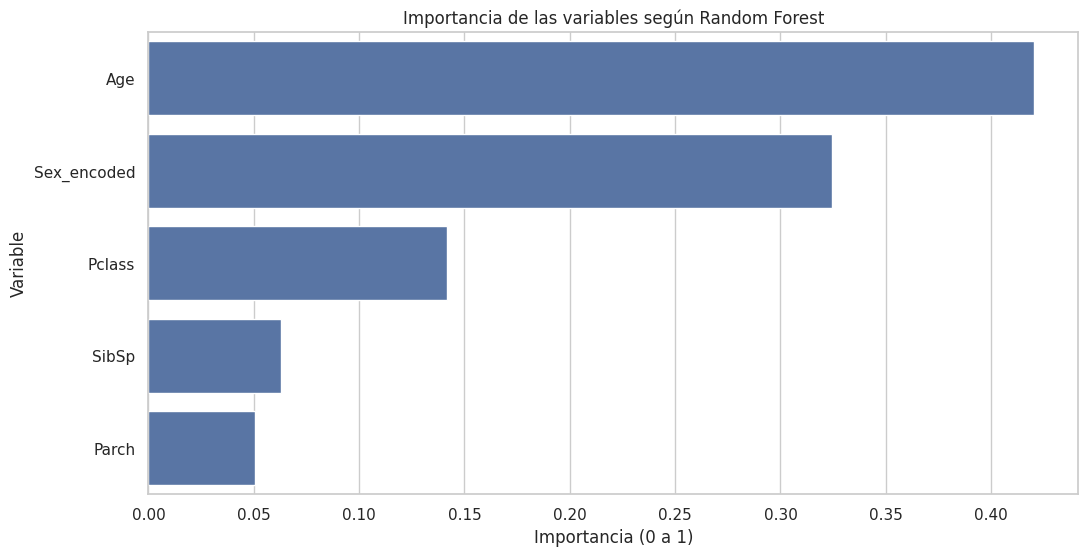

In [ ]:
# Extraemos la importancia de cada variable
importancias = modelo_rf.feature_importances_

# Asociamos cada valor con el nombre de la columna
variables = X.columns
df_importancia = pd.DataFrame({"Variable": variables, "Importancia": importancias})

# Ordenamos de mayor a menor
df_importancia = df_importancia.sort_values(by="Importancia", ascending=False)

# Gráfico de barras
sns.barplot(x="Importancia", y="Variable", data=df_importancia)
plt.title("Importancia de las variables según Random Forest")
plt.xlabel("Importancia (0 a 1)")
plt.ylabel("Variable")
plt.show()


## Conclusión y cierre

En este cuaderno entrenamos y evaluamos un modelo **Random Forest** para resolver un problema de clasificación con los datos del Titanic.

Pudimos observar que, al combinar muchos árboles distintos, el modelo logra una **precisión sólida (75%)**, con un buen equilibrio entre precisión y recall para ambas clases.  
Además, exploramos una de las ventajas clave de este algoritmo: **la capacidad de identificar qué variables fueron más relevantes** para las decisiones. En este caso, las más influyentes fueron `Age`, `Sex_encoded` y `Pclass`, lo que refuerza lo que ya habíamos intuido en cuadernos anteriores.

Comparado con un árbol de decisión individual, el `Random Forest` mostró **una mayor estabilidad** y mejor capacidad de generalización, aunque perdió parte de la interpretabilidad directa. Sin embargo, con herramientas como `feature_importances_`, pudimos recuperar parte de esa comprensión global.

Este cuaderno nos permitió ver en la práctica cómo funcionan los modelos de ensamble y cómo pueden potenciar nuestras predicciones con pocos ajustes.

En el próximo cuaderno nos enfocaremos en **automatizar todo el flujo de trabajo** con pipelines y validación cruzada. Esto nos permitirá organizar nuestros procesos de manera más limpia, reutilizable y profesional.

